# State-of-the-art for word-level intrinsic eval
Bruni, Tran, Baroni (multimodal dist semantics):
 - ws: 0.7
 - men: 0.77
TODO Need to find more recent papers

RG: http://aclweb.org/aclwiki/index.php?title=RG-65_Test_Collection_(State_of_the_art)
$\rho=0.89$

# Test: instrinsic eval on noise-corrupted vectors

Add noise as usual, evaluate intrinsically.

### Coverage
Vectors trained on less data will have lower coverage of types, so they may not be able to provide and answer for all word pairs in the test sets. I handle this in two ways:
 - relaxed: OOV items are not looked at. This may provide an unfair advantage to vectors trained on less data, because we forgive their poor coverage
 - strict: OOV items are assigned a random similarity score, resulting in zero correlation.
 
### PoS tags
Words in intrinsic datasets are provided without PoS tags (only MEN provides tags). These are stripped.
 
 
### Questions
 - Do people use the strict version?
 - What do I do with multiple possible POS tags per word for `ws353` data?

# Running experiment
Run `intrinsic_eval.py` first and make sure results are in the right place.

In [60]:
from common_imports import *

sns.timeseries.algo.bootstrap = my_bootstrap

In [61]:
df = pd.read_csv('intrinsic_noise_word_level.csv', index_col=0)
df['Dataset'] = df.test.map(str.upper)
rand_df = df[df.vect == 'random']
df = df[(df.vect == 'wtv-wiki-100') & (df.kind == 'strict')]
# df = df.drop(['test', 'vect'], axis=1)
noise_df = df
ORDER = ['MEN', 'SIMLEX', 'WS353', 'RG', 'MC']

SIZES = {'MEN':3000, 'SIMLEX':999, 'WS353':353, 'RG':65, 'MC':30}
df.head()

,vect,test,noise,kind,corr,pval,folds,Dataset
0,wtv-wiki-100,ws353,0.0,strict,0.616011,2.933340e-38,0,WS353
2,wtv-wiki-100,ws353,0.0,strict,0.631356,1.171413e-40,1,WS353
4,wtv-wiki-100,ws353,0.0,strict,0.650508,7.572071e-44,2,WS353
6,wtv-wiki-100,ws353,0.0,strict,0.650879,6.532893e-44,3,WS353
8,wtv-wiki-100,ws353,0.0,strict,0.665141,1.916624e-46,4,WS353


# Variance
What correlation would we have observed if we had chosen a slightly different set of words?

In [64]:
def fifth_perc(x):
    return np.percentile(x, 2.5)

def ninetieth_perc(x):
    return np.percentile(x, 97.5)

(df[df.noise == 0]
  .groupby('Dataset')
  .agg([np.mean, np.std, np.min, fifth_perc, ninetieth_perc, np.max])[['corr']]
  .reset_index()
  .set_index('Dataset'))

corr                                                        
             mean       std      amin fifth_perc ninetieth_perc      amax
Dataset                                                                  
MC       0.706692  0.118299  0.262270   0.424565       0.885996  0.941308
MEN      0.669094  0.009565  0.640832   0.650747       0.687208  0.696883
RG       0.716189  0.071229  0.406263   0.553507       0.825002  0.878758
SIMLEX   0.311460  0.029735  0.210645   0.248253       0.366731  0.408424
WS353    0.651173  0.032314  0.558636   0.591841       0.715795  0.741864

In [65]:
(rand_df[rand_df.noise == 0]
      .groupby('Dataset')
      .agg([np.mean, np.std, np.min, fifth_perc, ninetieth_perc, np.max])[['corr']]
      .reset_index()
      .set_index('Dataset'))

corr                                                        
             mean       std      amin fifth_perc ninetieth_perc      amax
Dataset                                                                  
MC      -0.011433  0.194190 -0.532289  -0.376014       0.358406  0.556800
MEN     -0.020496  0.018469 -0.076529  -0.057659       0.014765  0.044360
RG       0.080318  0.116584 -0.289848  -0.161769       0.309659  0.413221
SIMLEX   0.012068  0.031986 -0.094448  -0.049800       0.074456  0.119687
WS353   -0.077956  0.053735 -0.247995  -0.177403       0.026686  0.102410

# Empirical way to get mean correlation: via bootstrap 
This is the plot I had in my thesis

In [66]:
# not enough space, split in two subfigures
groups = {'MEN': 'A',
          'RG': 'A',
          'MC':'A',
          'SIMLEX': 'B',
          'WS353': 'B', }
df['group'] = df.Dataset.map(lambda x: groups[x])
df.head()

,vect,test,noise,kind,corr,pval,folds,Dataset,group
0,wtv-wiki-100,ws353,0.0,strict,0.616011,2.933340e-38,0,WS353,B
2,wtv-wiki-100,ws353,0.0,strict,0.631356,1.171413e-40,1,WS353,B
4,wtv-wiki-100,ws353,0.0,strict,0.650508,7.572071e-44,2,WS353,B
6,wtv-wiki-100,ws353,0.0,strict,0.650879,6.532893e-44,3,WS353,B
8,wtv-wiki-100,ws353,0.0,strict,0.665141,1.916624e-46,4,WS353,B


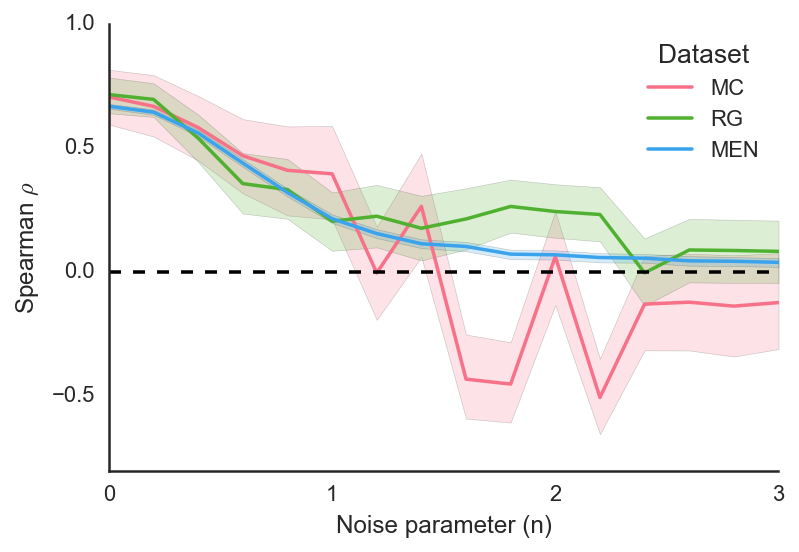

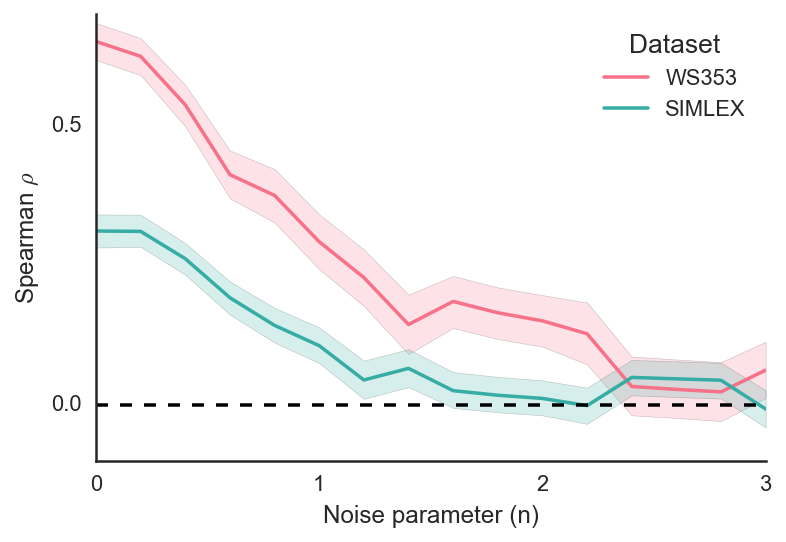

In [67]:
sns.set(font_scale=1.1)
sns.set_style("white")
for i, subdf in df.groupby('group'):
    sns.set_palette("cubehelix", 1)
    plt.figure(figsize=(6,4))
    ax = sns.tsplot(time='noise', value='corr', condition='Dataset', 
                unit='folds', ci=68, data=subdf)

    ax.axhline(0, c='k', linestyle='dashed')
    
    subset = rand_df[(rand_df.noise == 0) & (rand_df.Dataset == 'MC')]
#     ax.fill_between(rand_df.noise.unique(),
#                    fifth_perc(subset['corr']), 
#                    ninetieth_perc(subset['corr']),
#                    color='grey', alpha=0.5)

    sparsify_axis_labels(ax, x=1, y=.5)
    ax.set_ylabel('Spearman $\\rho$')
    ax.set_xlabel('Noise parameter (n)')
    sns.despine(ax=ax)#, bottom=True, left=True)
    plt.savefig('bootstrapped-corr-%s.pdf'%i, format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)